In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve,  f1_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from bayes_opt import BayesianOptimization
from sklearn.model_selection import RandomizedSearchCV



C:\Users\DELL\AppData\Local\Temp\ipykernel_5956\3798088592.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Load the dataset
data_path = 'Combined_Flights_small.csv'
data = pd.read_csv(data_path)

# Display general information about the dataset
print("Column Names:")
print(data.columns.tolist())
print("\nData Types:")
print(data.dtypes)
print("\nMissing Values:")
print(data.isnull().sum())
print("\nNumber of Unique Values:")
print(data.nunique())
print("\nTarget Variable Distribution:")
print(data['Disruption'].value_counts())

Column Names:
['Unnamed: 0', 'FlightDate', 'Airline', 'Origin', 'Dest', 'Cancelled', 'Diverted', 'CRSDepTime', 'CRSElapsedTime', 'Distance', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners', 'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline', 'Flight_Number_Marketing_Airline', 'Operating_Airline', 'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline', 'Tail_Number', 'Flight_Number_Operating_Airline', 'OriginAirportID', 'OriginAirportSeqID', 'OriginCityMarketID', 'OriginCityName', 'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac', 'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'DestCityName', 'DestState', 'DestStateFips', 'DestStateName', 'DestWac', 'DepTimeBlk', 'CRSArrTime', 'ArrDel15', 'ArrTimeBlk', 'DistanceGroup', 'Disruption']

Data Types:
Unnamed: 0                                   int64
FlightDate                                  object
Airline                       

In [3]:
# Step 1: Split the dataset into features (X) and the target variable (y)
# Exclude columns 'Unnamed: 0', 'Cancelled', 'Diverted', 'ArrDel15', and 'Disruption' from X
excluded_columns = ['Unnamed: 0', 'Cancelled', 'Diverted', 'ArrDel15', 'Disruption']

X = data.drop(columns=excluded_columns)  # Features (excluding excluded columns)
y = data['Disruption']  # Target variable

# Display the shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Step 2: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X: (29191, 42)
Shape of y: (29191,)
Shape of X_train: (23352, 42)
Shape of X_test: (5839, 42)
Shape of y_train: (23352,)
Shape of y_test: (5839,)


In [4]:


# Identify numeric and categorical features
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = data.select_dtypes(include=['object']).columns.tolist()

# Remove excluded columns from the lists of features
numeric_features = [feature for feature in numeric_features if feature not in excluded_columns]
categorical_features = [feature for feature in categorical_features if feature not in excluded_columns]

# Display the identified numeric and categorical features
print("Numeric Features:", numeric_features)
print("Categorical Features:", categorical_features)


Numeric Features: ['CRSDepTime', 'CRSElapsedTime', 'Distance', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'DOT_ID_Marketing_Airline', 'Flight_Number_Marketing_Airline', 'DOT_ID_Operating_Airline', 'Flight_Number_Operating_Airline', 'OriginAirportID', 'OriginAirportSeqID', 'OriginCityMarketID', 'OriginStateFips', 'OriginWac', 'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'DestStateFips', 'DestWac', 'CRSArrTime', 'DistanceGroup']
Categorical Features: ['FlightDate', 'Airline', 'Origin', 'Dest', 'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners', 'IATA_Code_Marketing_Airline', 'Operating_Airline', 'IATA_Code_Operating_Airline', 'Tail_Number', 'OriginCityName', 'OriginState', 'OriginStateName', 'DestCityName', 'DestState', 'DestStateName', 'DepTimeBlk', 'ArrTimeBlk']


In [5]:
# Define preprocessing steps for numerical and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
    ('scaler', StandardScaler())  # Standardize features by removing the mean and scaling to unit variance
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical variables
])

# Define column transformer to apply different preprocessing steps to different types of features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),  # Apply numeric transformer to numeric features
        ('cat', categorical_transformer, categorical_features)  # Apply categorical transformer to categorical features
    ],
    remainder='drop'  # Drop columns not specified in transformers
)

# Apply preprocessing to training and testing sets
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Display the shape of preprocessed training and testing sets
print("Shape of X_train_preprocessed:", X_train_preprocessed.shape)
print("Shape of X_test_preprocessed:", X_test_preprocessed.shape)


Shape of X_train_preprocessed: (23352, 9488)
Shape of X_test_preprocessed: (5839, 9488)


In [6]:
# Feature Engineering
# Extracting time-related features
X_train['DepartureHour'] = X_train['CRSDepTime'] // 100
X_test['DepartureHour'] = X_test['CRSDepTime'] // 100

# Encoding airlines as categorical variables
airline_cols = ['Airline', 'Operating_Airline']
for col in airline_cols:
    X_train[col + '_encoded'] = pd.factorize(X_train[col])[0]
    X_test[col + '_encoded'] = pd.factorize(X_test[col])[0]

# Extracting date components
X_train['FlightDate'] = pd.to_datetime(X_train['FlightDate'])
X_test['FlightDate'] = pd.to_datetime(X_test['FlightDate'])

X_train['Year'] = X_train['FlightDate'].dt.year
X_train['Month'] = X_train['FlightDate'].dt.month
X_train['Day'] = X_train['FlightDate'].dt.day

X_test['Year'] = X_test['FlightDate'].dt.year
X_test['Month'] = X_test['FlightDate'].dt.month
X_test['Day'] = X_test['FlightDate'].dt.day


# Display the updated shapes of X_train and X_test
print("Updated Shape of X_train:", X_train.shape)
print("Updated Shape of X_test:", X_test.shape)


Updated Shape of X_train: (23352, 46)
Updated Shape of X_test: (5839, 46)


In [7]:
# Define a list of selected attributes that are likely to predict disruption
selected_attributes = [
    'Year', 
    'Month', 
    'Day', 
    'DayOfWeek', 
    'DepartureHour',
    'CRSDepTime', 
    'CRSArrTime', 
    'CRSElapsedTime', 
    'Distance',
    'Airline_encoded',   # Engineered feature: Encoding of Airline
    'Operating_Airline_encoded'  # Engineered feature: Encoding of Operating Airline
]

# Subset the dataset with the selected attributes
X_selected = X_train[selected_attributes]

# Display the first few rows of the selected attributes
print(X_selected.head())


       Year  Month  Day  DayOfWeek  DepartureHour  CRSDepTime  CRSArrTime  \
9403   2019     12   23          1             19        1925        2309   
15788  2020     12   31          4             21        2103        2330   
5731   2019      1   24          4             17        1715        1815   
369    2018     12   20          4             17        1724        1900   
21362  2021      1   20          3             11        1135        1448   

       CRSElapsedTime  Distance  Airline_encoded  Operating_Airline_encoded  
9403              344      2105                0                          0  
15788             147       919                1                          1  
5731               60       187                2                          2  
369                96       335                3                          3  
21362             133       769                4                          4  


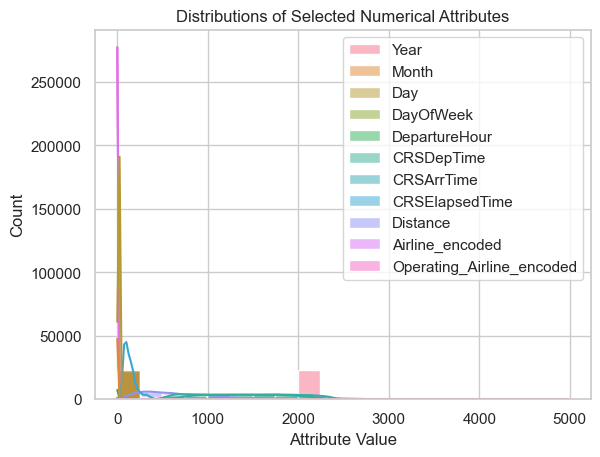

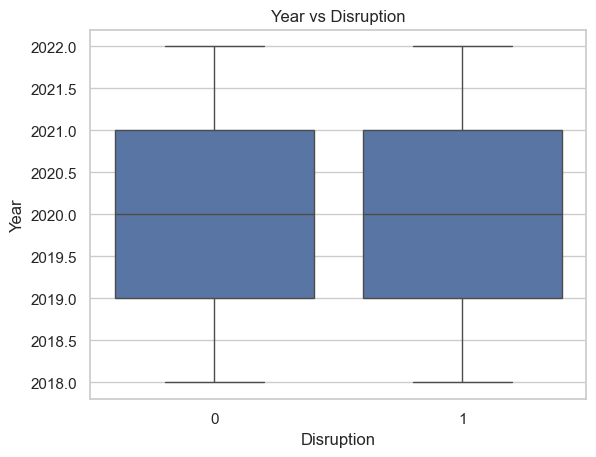

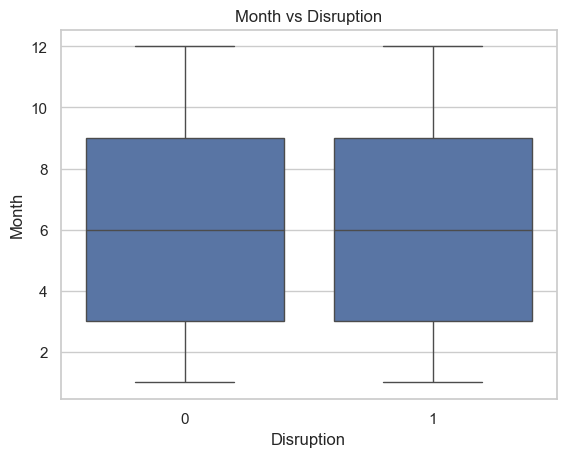

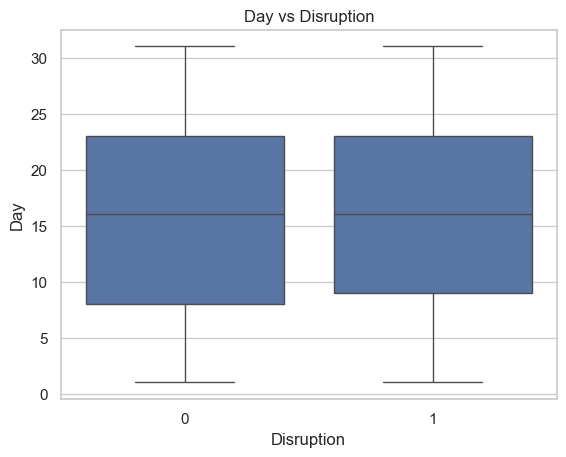

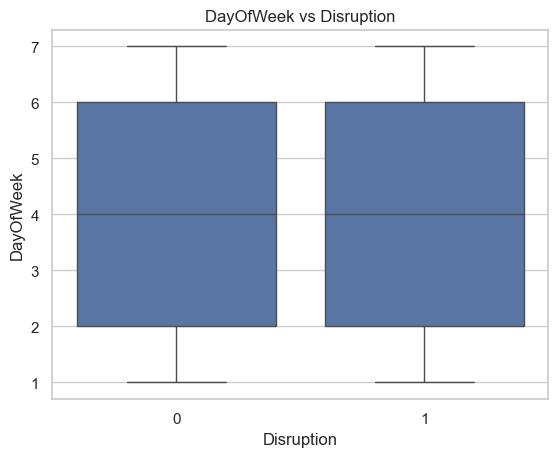

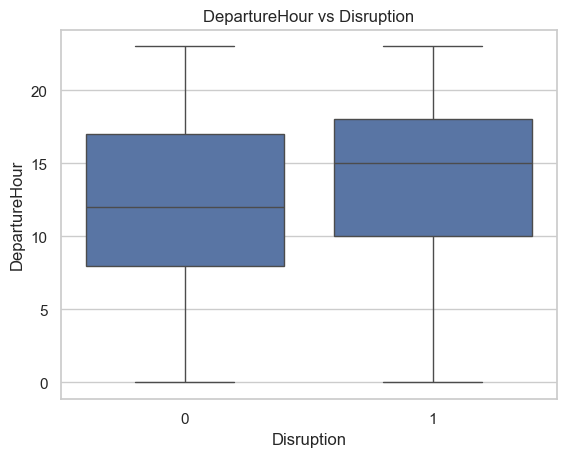

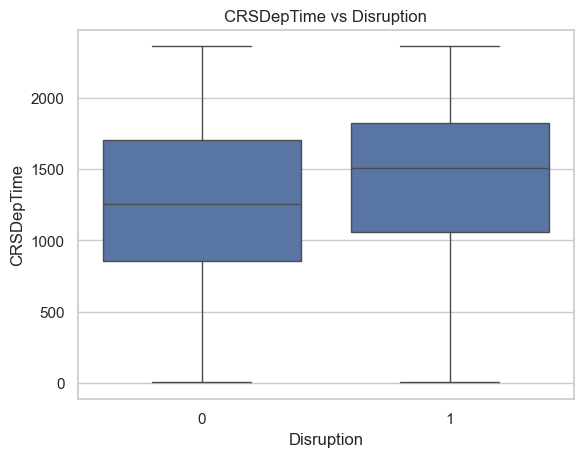

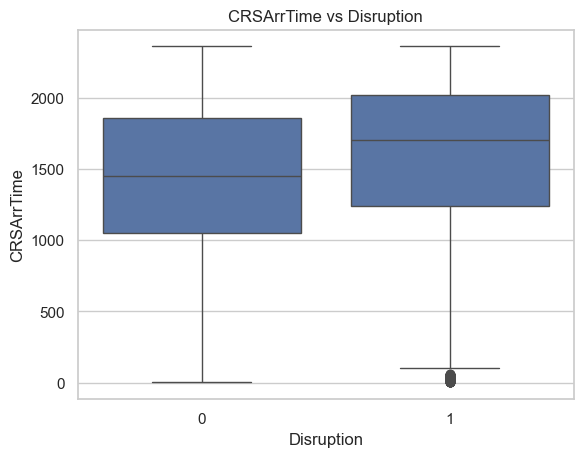

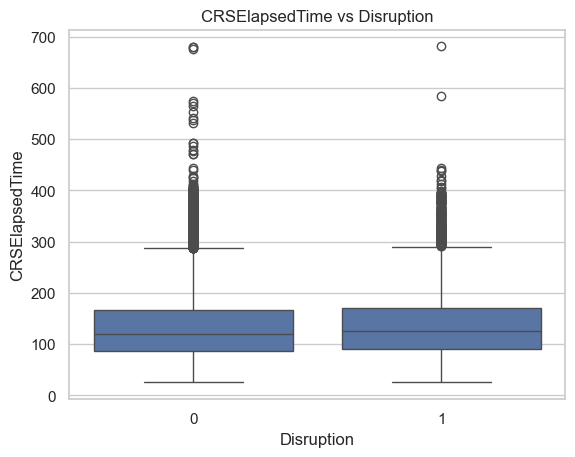

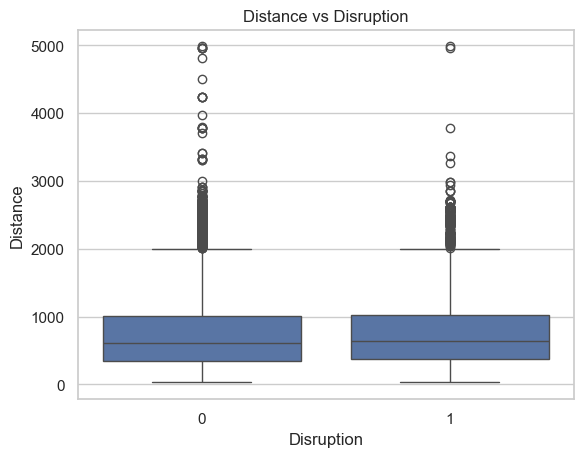

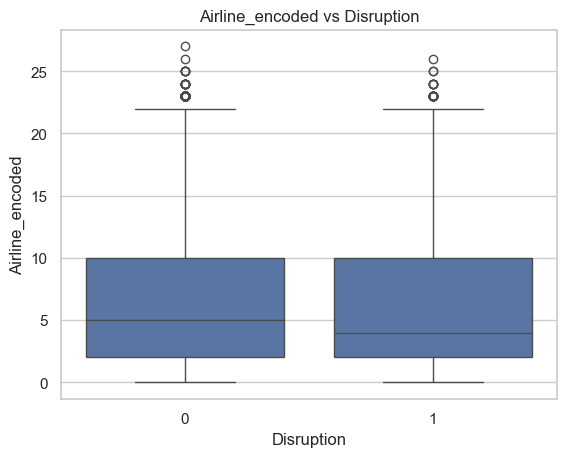

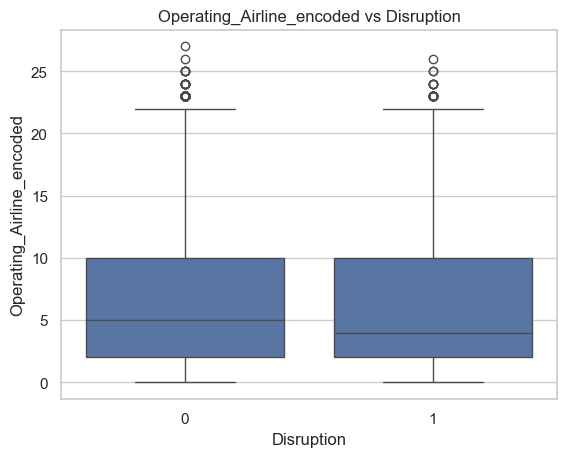

In [8]:
# Set the style for the plots
sns.set(style="whitegrid")

# Plot distributions of the selected numerical attributes
sns.histplot(data=X_selected, bins=20, kde=True)
plt.title('Distributions of Selected Numerical Attributes')
plt.xlabel('Attribute Value')
plt.show()

# Plot relationships between selected numerical attributes and the target variable (Disruption)
for attribute in selected_attributes:
    sns.boxplot(x=y_train, y=X_selected[attribute])
    plt.title(f'{attribute} vs Disruption')
    plt.xlabel('Disruption')
    plt.ylabel(attribute)
    plt.show()

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest Classifier Performance:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      4645
           1       0.83      0.06      0.11      1194

    accuracy                           0.81      5839
   macro avg       0.82      0.53      0.50      5839
weighted avg       0.81      0.81      0.73      5839


Logistic Regression Classifier Performance:
              precision    recall  f1-score   support

           0       0.81      0.95      0.88      4645
           1       0.43      0.14      0.21      1194

    accuracy                           0.79      5839
   macro avg       0.62      0.55      0.54      5839
weighted avg       0.73      0.79      0.74      5839


XGBoost Classifier Performance:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89      4645
           1       0.71      0.09      0.16      1194

    accuracy                           0.81      5839
   macro avg

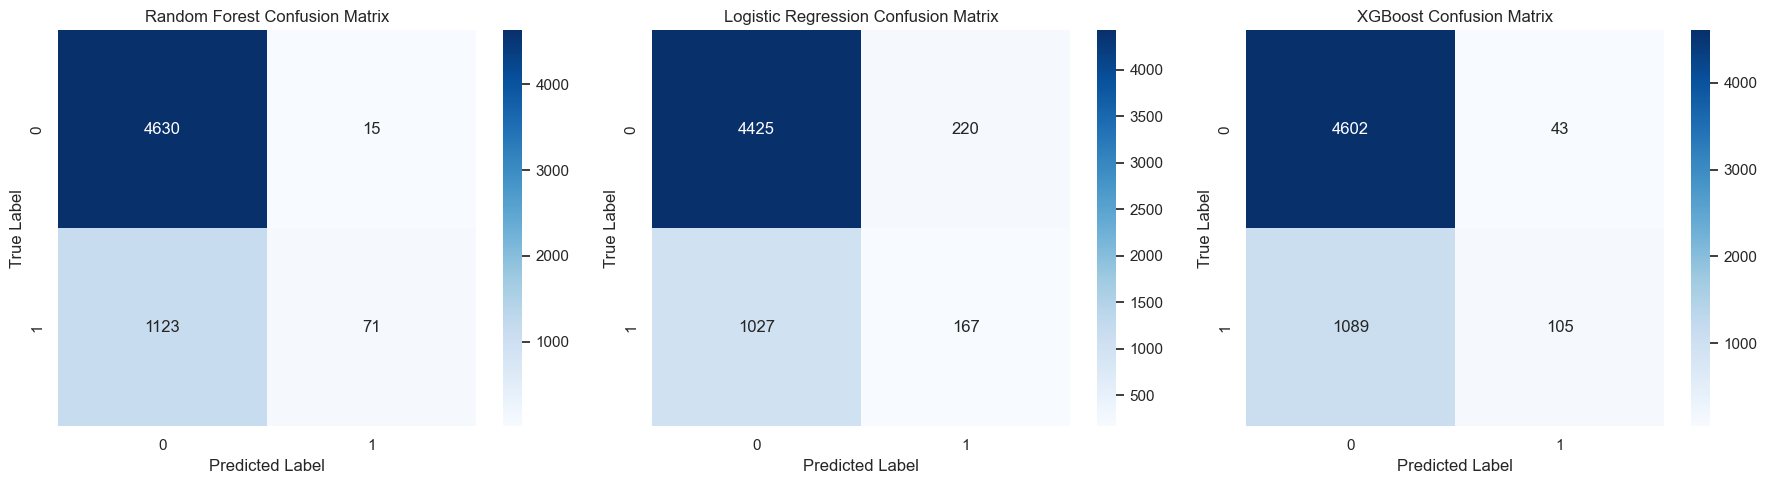

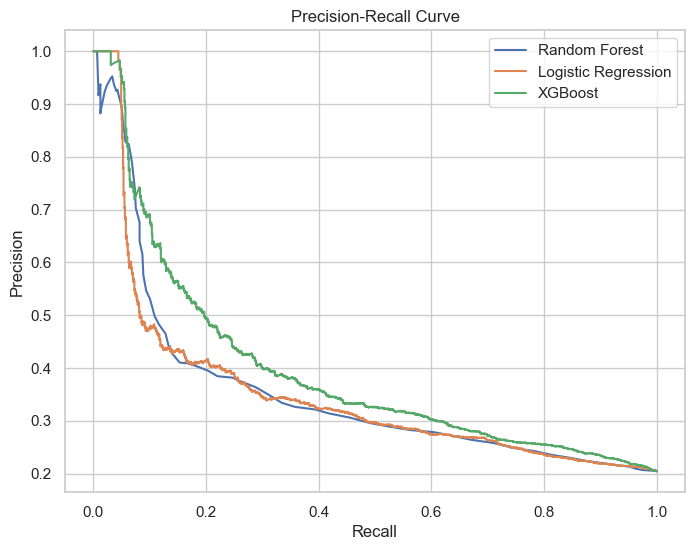

In [9]:
# Train Random Forest classifier
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train_preprocessed, y_train)

# Train Logistic Regression classifier
logistic_regression = LogisticRegression(random_state=42)
logistic_regression.fit(X_train_preprocessed, y_train)

# Train XGBoost classifier
xgboost_classifier = XGBClassifier(random_state=42)
xgboost_classifier.fit(X_train_preprocessed, y_train)

# Make predictions on the test set for each model
y_pred_random_forest = random_forest.predict(X_test_preprocessed)
y_pred_logistic_regression = logistic_regression.predict(X_test_preprocessed)
y_pred_xgboost = xgboost_classifier.predict(X_test_preprocessed)

# Evaluate performance
print("Random Forest Classifier Performance:")
print(classification_report(y_test, y_pred_random_forest))
print("\nLogistic Regression Classifier Performance:")
print(classification_report(y_test, y_pred_logistic_regression))
print("\nXGBoost Classifier Performance:")
print(classification_report(y_test, y_pred_xgboost))

# Plot confusion matrix for each model
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Random Forest
sns.heatmap(confusion_matrix(y_test, y_pred_random_forest), annot=True, cmap='Blues', fmt='g', ax=axes[0])
axes[0].set_title('Random Forest Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Logistic Regression
sns.heatmap(confusion_matrix(y_test, y_pred_logistic_regression), annot=True, cmap='Blues', fmt='g', ax=axes[1])
axes[1].set_title('Logistic Regression Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

# XGBoost
sns.heatmap(confusion_matrix(y_test, y_pred_xgboost), annot=True, cmap='Blues', fmt='g', ax=axes[2])
axes[2].set_title('XGBoost Confusion Matrix')
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('True Label')

plt.tight_layout()
plt.show()

# Plot precision-recall curve for each model
fig, ax = plt.subplots(figsize=(8, 6))

# Random Forest
precision_rf, recall_rf, _ = precision_recall_curve(y_test, random_forest.predict_proba(X_test_preprocessed)[:, 1])
plt.plot(recall_rf, precision_rf, label='Random Forest')

# Logistic Regression
precision_lr, recall_lr, _ = precision_recall_curve(y_test, logistic_regression.predict_proba(X_test_preprocessed)[:, 1])
plt.plot(recall_lr, precision_lr, label='Logistic Regression')

# XGBoost
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, xgboost_classifier.predict_proba(X_test_preprocessed)[:, 1])
plt.plot(recall_xgb, precision_xgb, label='XGBoost')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()



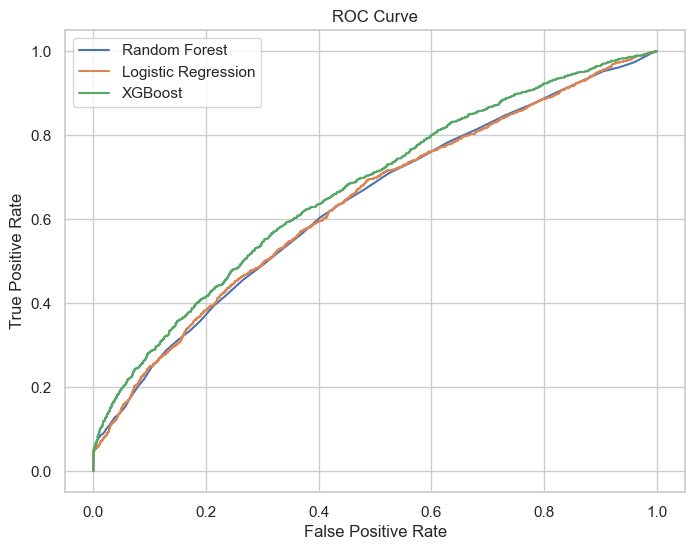

F1 Score for Random Forest: 0.11
F1 Score for Logistic Regression: 0.21
F1 Score for XGBoost: 0.16


In [10]:
# Plot ROC curve for each model
fig, ax = plt.subplots(figsize=(8, 6))

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, random_forest.predict_proba(X_test_preprocessed)[:, 1])
plt.plot(fpr_rf, tpr_rf, label='Random Forest')

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, logistic_regression.predict_proba(X_test_preprocessed)[:, 1])
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgboost_classifier.predict_proba(X_test_preprocessed)[:, 1])
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Calculate F1 score for each model
f1_rf = f1_score(y_test, y_pred_random_forest)
f1_lr = f1_score(y_test, y_pred_logistic_regression)
f1_xgb = f1_score(y_test, y_pred_xgboost)

print(f"F1 Score for Random Forest: {f1_rf:.2f}")
print(f"F1 Score for Logistic Regression: {f1_lr:.2f}")
print(f"F1 Score for XGBoost: {f1_xgb:.2f}")

In [11]:
# Define the parameter distributions
param_distributions = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}


# Initialize the random forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_distributions,
                                   n_iter=20, scoring='recall', random_state=42, n_jobs=-1)

# Perform random search
random_search.fit(X_train_preprocessed, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
test_score = best_model.score(X_test_preprocessed, y_test)
print("Test Accuracy with Best Model:", test_score)


### Hyperparameter Tuning with RandomizedSearchCV

In this code snippet, we're using `RandomizedSearchCV` to fine-tune the hyperparameters of a Random Forest classifier (`RandomForestClassifier`). The goal is to find the set of hyperparameters that maximizes the recall score on our validation set.

#### Why RandomizedSearchCV?

`RandomizedSearchCV` is a technique used for hyperparameter tuning that samples from a distribution of possible hyperparameter values. Unlike exhaustive grid search, which tries every possible combination of hyperparameters, randomized search explores a random subset of the hyperparameter space. This makes it computationally less expensive, especially when dealing with a large number of hyperparameters or a large dataset.

#### Single Validation Set

In this particular case, we've opted to use a single validation set (`cv=1`) instead of cross-validation (`cv=3`). The decision to use a single validation set was made due to limited computational resources or time constraints. 

While cross-validation provides a more robust estimate of model performance by averaging results over multiple folds, it can be computationally expensive, especially when training on large datasets or when hyperparameter tuning involves many iterations. By using a single validation set, we can significantly reduce the computational burden while still obtaining a reasonable estimate of the model's performance.

#### Code Explanation

- We define a dictionary `param_distributions` specifying the hyperparameter distributions to search over.
- We initialize a `RandomForestClassifier` with a specified random state for reproducibility.
- Using `RandomizedSearchCV`, we perform hyperparameter tuning with 100 iterations (`n_iter=100`), using recall as the scoring metric (`scoring='recall'`).
- By setting `cv=1`, we specify that we're using a single validation set for evaluating each combination of hyperparameters.
- After the search, we extract the best hyperparameters (`best_params`) and evaluate the best model's accuracy on the test set.

Overall, this approach allows us to efficiently search the hyperparameter space and find a well-performing model while respecting computational constraints.




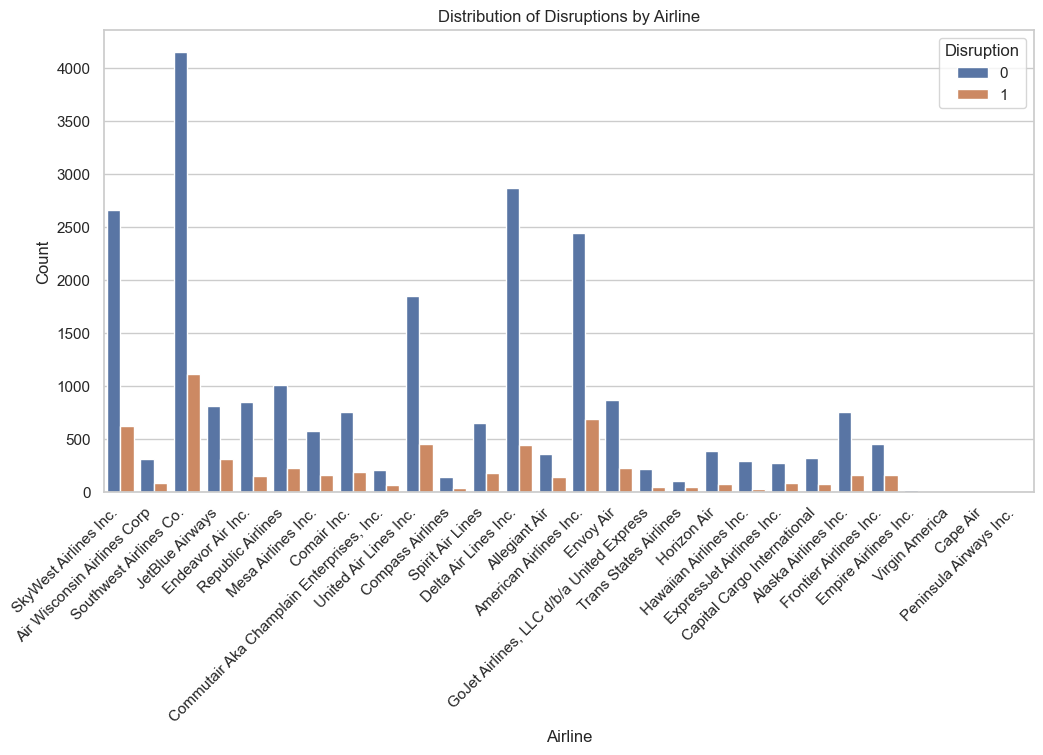

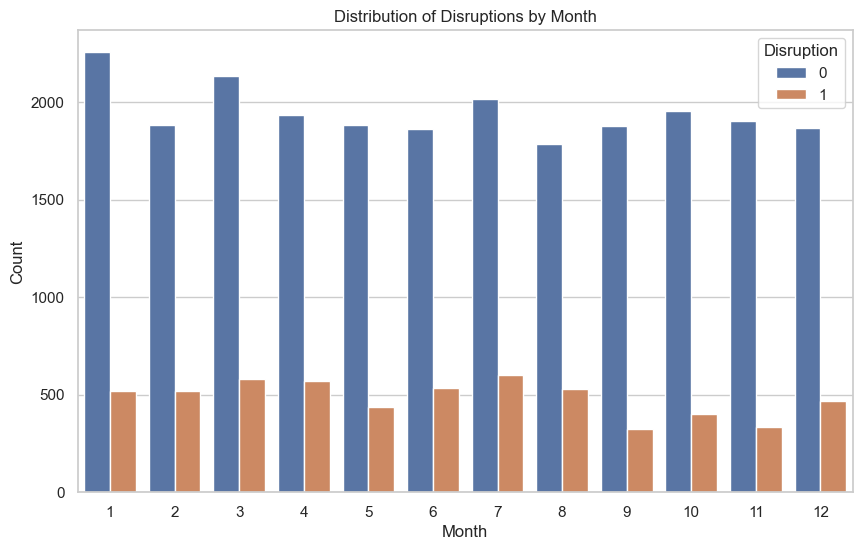

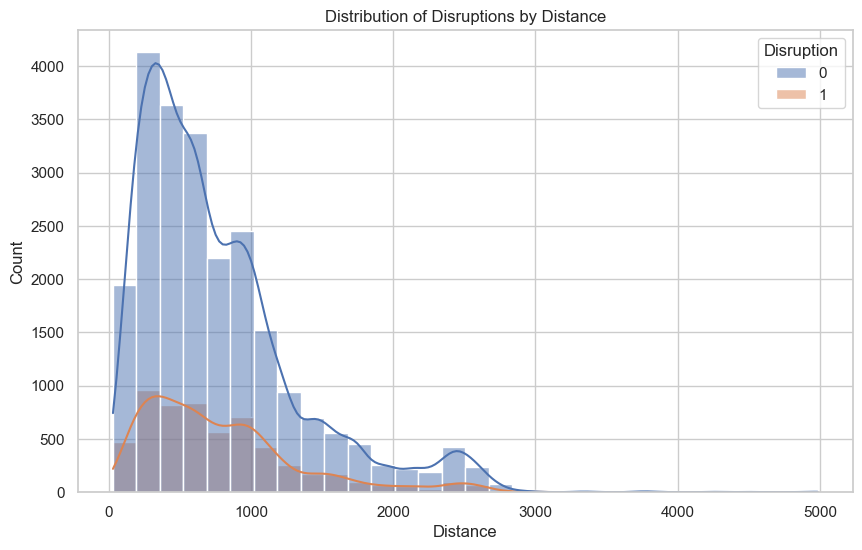

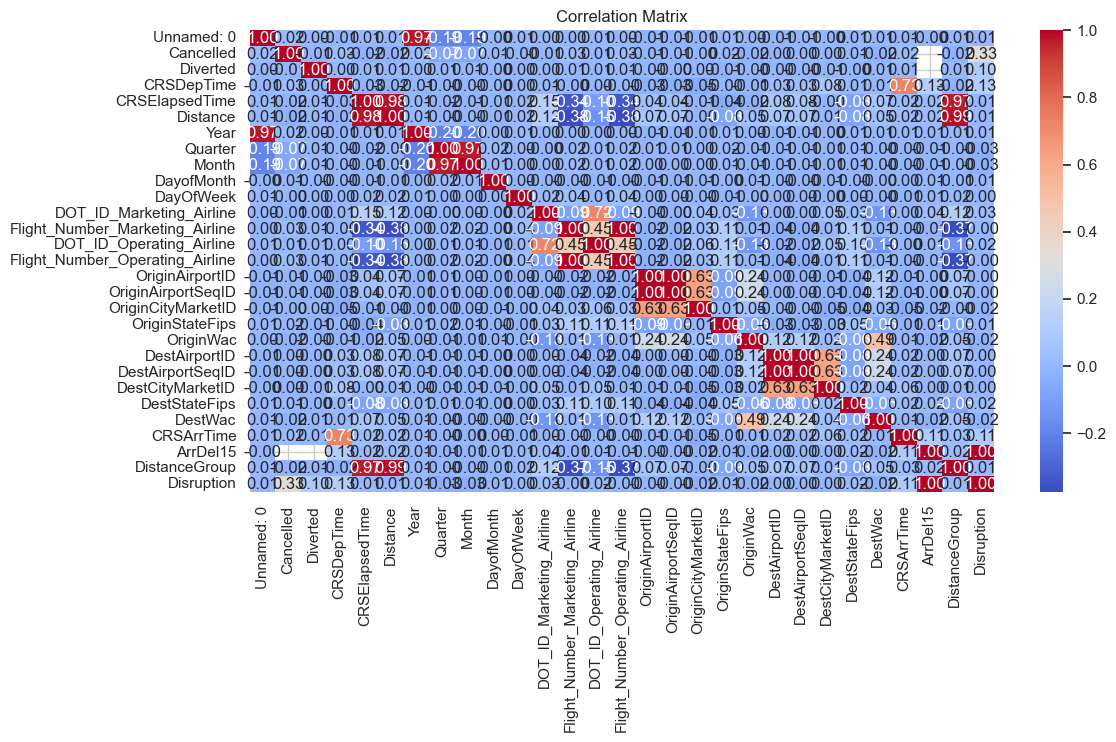

In [ ]:
# Visualize the distribution of 'Airline' with respect to 'Disruption'
plt.figure(figsize=(12, 6))
sns.countplot(x='Airline', hue='Disruption', data=data)
plt.title('Distribution of Disruptions by Airline')
plt.xlabel('Airline')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

# Visualize the distribution of disruptions over months
plt.figure(figsize=(10, 6))
sns.countplot(x='Month', hue='Disruption', data=data)
plt.title('Distribution of Disruptions by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

# Visualize the distribution of disruptions over distance
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Distance', hue='Disruption', bins=30, kde=True)
plt.title('Distribution of Disruptions by Distance')
plt.xlabel('Distance')
plt.ylabel('Count')
plt.show()

# Exclude non-numeric columns before visualizing the correlation matrix
numeric_data = data.select_dtypes(include=['int64', 'float64'])

# Visualize the correlation matrix for numerical attributes
plt.figure(figsize=(12, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()
